# Detecting network intrusions & anomalies with higher-order topological kernels via quantum computation 

### 0. CONSTRUCTING NUMPY DATASETS

In [ ]:
import pandas as pd
import numpy as np

# Load the CSV from big dataset
filename = 'BCCC-CIC-CSE-IDS2018/Friday-02-03-2018/friday_02_03_2018_bot/friday_02_03_2018_bot.csv'

# Load the first 50 rows
df = pd.read_csv(filename, nrows=500)

# Select the top 5 anomaly-related features
selected_features = [
    'total_payload_bytes',
    'bytes_rate',
    'packets_rate',
    'avg_segment_size',
    'duration',
    'fwd_bytes_rate',
    'bwd_bytes_rate',
    'syn_flag_counts'

]

# Extract the relevant features
features_df = df[selected_features]

# # Save as CSV
# features_df.to_csv('CSV-500-botnet-benign.csv', index=False)

# Save as a NumPy array
features_array = features_df.to_numpy()
np.save('500-botnet-attack.npy', features_array)


: 

## BEGIN - TRAINING VECTORS & LOAD DATA

In [129]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import numpy as np
from quask.core import Ansatz, Kernel, KernelFactory, KernelType, Operation

from quask.core_implementation import QiskitKernel

In [130]:
import pandas as pd

# Specify the columns you want to load
cols = ["duration", "packets_rate", "total_payload_bytes", "syn_flag_counts", "avg_segment_size", "fwd_bytes_rate", "bwd_bytes_rate", "ack_flag_counts", "fwd_avg_segment_size", "packets_count", "bytes_rate", "avg_fwd_bytes_per_bulk", "idle_mean", "fwd_packets_IAT_mean", "payload_bytes_variance"]

# cols = ["duration", "packets_rate", "total_payload_bytes", "bytes_rate", "syn_flag_counts", "avg_segment_size", "fwd_bytes_rate", "bwd_bytes_rate"]

# Load only the first 200 rows and selected columns
qX1 = pd.read_csv(
    'BCCC-CIC-CSE-IDS2018/Wednesday_21_02_2018/wednesday_21_02_2018_benign_part2/wednesday_21_02_2018_benign_part2.csv',
    usecols=cols,
    nrows=20
).to_numpy()

qX2 = pd.read_csv(
    'BCCC-CIC-CSE-IDS2018/Wednesday_21_02_2018/wednesday_21_02_2018_hoic_part2/wednesday_21_02_2018_hoic_part2.csv',
    usecols=cols,
    nrows=20
).to_numpy()


In [131]:
# qX1 = np.load('hoic2benign_200.npy', allow_pickle=True)
# qX2 = np.load('hoic2attack_200.npy', allow_pickle=True)

In [132]:
# columns = [3, 4, 5, 6, 7, 8, 9, 10]
# qX1 = qX1[:200,columns]
# qX2 = qX2[:200,columns]

In [133]:
qX = np.row_stack([qX1, qX2])
qy = np.array([-1] * len(qX1) + [1] * len(qX2))

print(f"{qX.shape=}")
print(f"{qy.shape=}")

qX.shape=(40, 15)
qy.shape=(40,)


In [134]:
qX_train, qX_test, qy_train, qy_test = train_test_split(qX, qy, test_size=0.2, random_state=42)

print("Shape training set:", qX_train.shape, qy_train.shape)
print("Shape testing set:", qX_test.shape, qy_test.shape)
print("Example of feature:", qX_train[0])
print("Example of label:", qy_train[0])

Shape training set: (32, 15) (32,)
Shape testing set: (8, 15) (8,)
Example of feature: [3.43189240e-02 9.00000000e+00 1.19500000e+03 8.70172840e+04
 5.20000000e+01 1.32777778e+02 0.00000000e+00 3.48204391e+04
 7.57599511e+03 2.72444440e+04 2.62245985e+02 0.00000000e+00
 2.00000000e+00 8.00000000e+00 8.60000000e-03]
Example of label: 1


In [135]:
# Instantiate a machine learning model
model = SVC(kernel='precomputed')

## BUILD QUANTUM KERNEL

In [136]:
from quask.core_implementation.qiskit_kernel import QiskitKernel
from quask.core import KernelType
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Sampler

# SIMULATED AER BACKEND
def create_qiskit_noiseless(ansatz, measurement: str, type: KernelType):
    # Here platform="infty_shots" forces Estimator/Aer path inside QiskitKernel
    return QiskitKernel(
        ansatz,
        measurement,
        type,
        platform="infty_shots",
        n_shots=None  # None means no sampling, use statevector/estimator
    )

# REAL QUANTUM BACKEND
# _service = QiskitRuntimeService()  # ensure credentials/configured
# backend = _service.backend("ibm_rensselaer", instance="rpi-rensselaer/classes/itws-4940-callab")
# options = {
#     "dynamical_decoupling": {"sequence_type": "XX", "enable": False},
#     "twirling": {"enable_gates": False, "enable_measure": False, "num_randomizations": "auto", "shots_per_randomization": "auto"}
# }

# # Example factory for a real IBM backend with given options
# def create_qiskit_ibm(ansatz, measurement: str, type: KernelType):
#     return QiskitKernel(
#         ansatz,
#         measurement,
#         type,
#         platform="ibm_quantum",    # or leave default so QiskitKernel picks job mode
#         n_shots=2048,
#         options=options,
#         backend=backend,
#     )

Add to Factory

In [137]:
from quask.core import KernelFactory, Ansatz

# Register the noiseless factory
# KernelFactory.add_implementation('qiskit_noiseless', create_qiskit_noiseless)
# Register the IBM backend factory
# KernelFactory.add_implementation('qiskit_ibm', create_qiskit_ibm)

# Choose which one is the default for create_kernel calls:
KernelFactory.set_current_implementation('qiskit_noiseless')
# ...later, if you want to switch:
# KernelFactory.set_current_implementation('qiskit_ibm')

In [138]:
# print(qX_train)
# print(qy_train)

Define ansatz ops

In [139]:
# # Define some information about the parameterized quantum circuit
# N_FEATURES = 3
# N_QUBITS = 3

# # Create a random operation
# allowed_generators = Operation.PAULI_GENERATORS
# generators = np.random.choice(allowed_generators)

# allowed_qubits = list(range(N_QUBITS))
# wires = np.random.choice(allowed_qubits, 2, replace=False)

# allowed_features_plus_constant_element = list(range(N_FEATURES + 1))
# feature = np.random.choice(allowed_features_plus_constant_element)

# bandwidth = np.random.uniform(0.0, 1.0)

# operation = Operation(generators, wires, feature, bandwidth)
# print(operation)

In [140]:
# N_FEATURES = 3
# N_OPERATIONS = 3
# N_QUBITS = 3
# ansatz = Ansatz(n_features=N_FEATURES, n_qubits=N_QUBITS, n_operations=N_OPERATIONS)
# ansatz.initialize_to_identity()

# # parameterized rotation R_{ZZ}(x_0) on the qubits 0, 1
# ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="ZZ", new_bandwidth=1.0)

# # parameterized rotation R_{XX}(x_1) on the qubits 0, 1
# ansatz.change_operation(1, new_feature=1, new_wires=[0, 1], new_generator="XX", new_bandwidth=1.0)

# # constant R_x(0.123) of the qubit 1 (the second)
# ansatz.change_operation(2, new_feature=2, new_wires=[0, 1], new_generator="IX", new_bandwidth=0.123)

In [141]:
# ansatz = Ansatz(n_features=1, n_qubits=1, n_operations=1)
# ansatz.initialize_to_identity()
# # e.g. set operations...
# ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.1)
# ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.1)
# ansatz.change_operation(2, new_feature=2, new_wires=[2, 1], new_generator="XZ", new_bandwidth=0.1)

In [ ]:
ansatz = Ansatz(n_features=15, n_qubits=4, n_operations=15)
ansatz.initialize_to_identity()
# e.g. set operations...
ansatz.change_operation(0, new_feature=0, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.2)
ansatz.change_operation(1, new_feature=1, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.2)
ansatz.change_operation(2, new_feature=2, new_wires=[2, 3], new_generator="XZ", new_bandwidth=0.2)
ansatz.change_operation(3, new_feature=3, new_wires=[3, 0], new_generator="YX", new_bandwidth=0.2)
ansatz.change_operation(4, new_feature=4, new_wires=[0, 1], new_generator="YY", new_bandwidth=0.2)
ansatz.change_operation(5, new_feature=5, new_wires=[1, 2], new_generator="YZ", new_bandwidth=0.2)
ansatz.change_operation(6, new_feature=6, new_wires=[2, 3], new_generator="ZX", new_bandwidth=0.2)
ansatz.change_operation(7, new_feature=7, new_wires=[3, 0], new_generator="ZY", new_bandwidth=0.2)

ansatz.change_operation(8, new_feature=8, new_wires=[0, 1], new_generator="XX", new_bandwidth=0.2)
ansatz.change_operation(9, new_feature=9, new_wires=[1, 2], new_generator="XY", new_bandwidth=0.2)
ansatz.change_operation(10, new_feature=10, new_wires=[2, 3], new_generator="XZ", new_bandwidth=0.2)
ansatz.change_operation(11, new_feature=11, new_wires=[3, 0], new_generator="YX", new_bandwidth=0.2)
ansatz.change_operation(12, new_feature=12, new_wires=[0, 1], new_generator="YY", new_bandwidth=0.2)
ansatz.change_operation(13, new_feature=13, new_wires=[1, 2], new_generator="ZX", new_bandwidth=0.2)
ansatz.change_operation(14, new_feature=14, new_wires=[2, 3], new_generator="ZY", new_bandwidth=0.2)


Create KernelFactory

In [169]:
# kernel = KernelFactory.create_kernel(ansatz, "ZZZ", KernelType.FIDELITY)

In [170]:
kernel = KernelFactory.create_kernel(ansatz, "ZZZZ", KernelType.FIDELITY)

# kernel.service = _service # This will invoke whichever implementation is current (e.g., create_qiskit_noiseless).

Set up a Session

In [171]:
# batch all jobs in a session
# with Session(backend=backend) as session:
#     kernel._session = session
#     kernel._sampler = Sampler(session=session)

#     K_train = kernel.build_kernel(X_train, X_train, matrix="train")


K_train = kernel.build_kernel(qX_train, qX_train, matrix="train") # train data
print(K_train)

[[ 1.          0.16368936  0.58885924 ... -0.0392661   0.03567528
   0.03567528]
 [ 0.16368936  1.          0.12928285 ... -0.1497693   0.12067818
   0.12067818]
 [ 0.58885924  0.12928285  1.         ... -0.08728885  0.07278955
   0.07278955]
 ...
 [-0.0392661  -0.1497693  -0.08728885 ...  1.         -0.80253219
  -0.80253219]
 [ 0.03567528  0.12067818  0.07278955 ... -0.80253219  1.
   1.        ]
 [ 0.03567528  0.12067818  0.07278955 ... -0.80253219  1.
   1.        ]]


Fit trained data to model

In [172]:
model.fit(K_train, qy_train)

SVC(kernel='precomputed')

In [173]:
# Predict the labels for the test data
K_test = kernel.build_kernel(qX_test, qX_train, matrix="test")
y_pred = model.predict(K_test)

In [174]:
# Calculate the accuracy
accuracy = np.sum(qy_test == y_pred) / len(qy_test)
print("Accuracy:", accuracy)

Accuracy: 0.75


## Visualizations

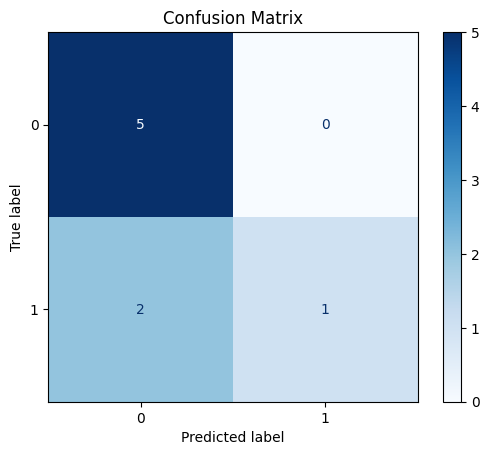

In [175]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from matplotlib import pyplot as plt

cm = confusion_matrix(qy_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()